In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Activation

import tensorboard

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Pra

directory ='/content/drive/MyDrive/Pra/image'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Pra


Importing Images and Pre processing
The images are stored in a directory specified by the directory variable, and the image_dataset_from_directory function from the tf.keras.utils module is used to create a tf.data.Dataset object from the image files in this directory.

The labels argument specifies that the labels for the images should be inferred from the directory structure, with each subdirectory corresponding to a class. The class_names argument was set to None, to infer class names from the subdirectory names.

It reads images of 32 batches to improve performance and resource management with (222, 224) image size and images should be shuffled randomly before being split into training and evaluation sets

For interpolation "lanczos5" was used to resizing the images as it gives better quality when rescalling.

The output of the image_dataset_from_directory function indicates that it found 2985 images belonging to 5 classes. This information is useful for understanding the distribution of the classes in the dataset.

In [6]:
directory = 'image'
image_size = (222,294)

# Generates a tf.data.Dataset from image files in a directory.
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size = image_size,
    shuffle=True,
    seed=2,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    crop_to_aspect_ratio=False,
)

Found 2285 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
print(class_names)
print('batches in dataset:',len(dataset))

['Acne', 'Cyst, tumour and skin-tags', 'Melanoma', 'Normal skin']
batches in dataset: 72


Splittign the dataset into train and test sets

In [8]:
# tf.take(30) will take 30 image sets from the dataset
# tf.skip(30) will skip 30 image sets from the dataset
# doesn't need to shuffle as the dataset as it is already shuffled

test_ds = dataset.take(30)
val_ds = test_ds.take(20)
test_ds = test_ds.skip(20)

train_ds = dataset.skip(30)

This code is splitting a dataset into train, validation, and test sets for the purpose of building and evaluating a machine learning model.

The validation set is used to tune the model's hyperparameters and the test set is used to evaluate the model's performance on unseen data. The train set is used to train the model. This is a common practice to ensure that the model generalizes well to new data. The lengths of the resulting datasets are printed to verify the split.

The code first splits off the first 30 examples from the dataset and assigns them to the test_ds variable. It then takes the first 20 examples from test_ds and assigns them to the val_ds variable, which will be used for validation during training. The remaining 10 examples in test_ds will be used for testing the model's performance after training.

The rest of the examples in the original dataset (all examples after the first 30) are then assigned to the train_ds variable, which will be used for training the model.

In [9]:
print(len(dataset), len(train_ds), len(val_ds), len(test_ds))

72 42 20 10


Handling Unbalaced classes
My main focus here is acne class as it is the most under represented class.

This code checks if a directory called "Acne" exists in the current working directory. If it does not exist, the code constructs the path to the "Acne" data directory in the "datathon 2022 dataset" directory and uses the shutil library to copy the "Acne" directory and all its contents to the current working directory. The new "Acne" directory will contain a subdirectory called "Acne" with the actual data files. This code may be used to create a local copy of the "Acne" data that is easier to access and manipulate, or to create a backup of the original data in case it is lost or corrupted.

The reason for this is that, acne dataset has only 400 images but some other classes have 700. The plan is to over sample the data with augmented acne images.

In [10]:
if not os.path.exists('Acne'):
    path = os.path.join(os.getcwd(),"image", 'Acne')
    import shutil
    shutil.copytree(path, 'Acne/Acne')

The copied acne images are stored in a directory specified by the directory variable, and the image_dataset_from_directory function from the tf.keras.utils module is used to create a tf.data.Dataset object from the image files in this directory.

The output of the image_dataset_from_directory function indicates that it found 390 files belonging to acne class.

In [11]:
directory = 'Acne'
image_size = (222, 294)

# Generates a tf.data.Dataset from image files in a directory.
acne_dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=2,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    crop_to_aspect_ratio=False,
)

# Define a function to apply image augmentation
# def augment(image, label):
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_brightness(image, max_delta=0.4)
#   image = tf.image.random_saturation(image, lower=0.5, upper=1.2)
#   image = tf.image.random_contrast(image, lower=0.5, upper=1.3)
#   image = tf.image.random_hue(image, max_delta=0.1)
#   image = tf.image.random_flip_up_down(image)
#   image = tf.image.random_crop(image, size=[222, 294, 3])
#   return image, label

# # Use the map method to apply the augment function to each element in the dataset
# augmented_dataset = acne_dataset.map(augment)

augmented_dataset = acne_dataset

print(acne_dataset.class_names)
print('batches in acne_dataset:',len(acne_dataset))

Found 390 files belonging to 1 classes.
['Acne']
batches in acne_dataset: 13


When fixing unbalanceness, Data augmentaion does not nesessary in this step as tensorflow mentioned "Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers". :- Data Augmentation will be done in a later step as tensorflow recommended.

Make Train Dataset more represended with under represented class.
Concatenate method is used to combine two datasets, augmented_dataset.take(6).unbatch() and train_ds.unbatch(). The take method is used to select the first 6 elements of the augmented_dataset and the unbatch method is used to transform a dataset of batched examples into a dataset of individual examples. The concatenate method combines these two datasets by appending the elements of the second dataset to the end of the first.

The resulting dataset is shuffled using the shuffle method and then batched using the batch method. The shuffle method randomly shuffles the elements of the dataset using a buffer with a specified size. The batch method combines the elements of the dataset into batches of a specified size.

These actions are being taken to prepare the combined dataset for use in training a machine learning model. Shuffling the data helps to ensure that the model is not biased by the order of the examples and batching the data can make training more efficient.

In [12]:
# combine acne_dataset and dataset
df = tf.data.Dataset.concatenate(augmented_dataset.take(6).unbatch(), train_ds.unbatch())

# shuffle the dataset
df = df.shuffle(buffer_size=100).batch(32)

It visualizes a small sample of images from the dataset with their corresponding labels. The purpose of this visualization could be to check the quality of the data or to get a sense of the class distribution in the dataset.

A figure with a 3x3 grid of subplots is created using the plt.figure and plt.subplot functions. The df.take(1) method is used to retrieve the first element from a dataset df as a tuple of images and labels.

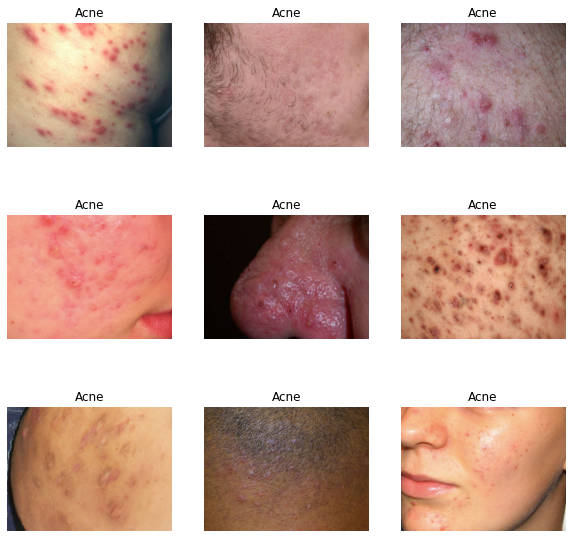

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in df.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Better performance with cache and prefetch
In the below code, the cache and prefetch methods are applied to the train, validation, and test datasets to improve the efficiency of the input pipeline and to speed up the training and evaluation process.

The cache method stores the elements of the dataset in memory so that they can be reused without needing to recreate the dataset from the original data. The prefetch method prefetches elements from the dataset in a background thread, so that they are ready to be used when the model is ready to consume them.


In [14]:
# cache the dataset in the memory to improve performance
# prefetch the dataset to improve performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

The purpose of this data augmentation pipeline is to be used in conjunction with the model training loop to generate augmented versions of training data on the fly. This can help to improve the model's performance by introducing more diversity in the training data.

The above code defines a data augmentation pipeline using the Sequential class from the tf.keras.layers module. Data augmentation is a technique used to artificially increase the size of a dataset by generating modified versions of existing data. This can be useful for training machine learning models because it helps to reduce overfitting and can lead to better generalization to new data.

The pipeline consists of several layers that randomly apply various transformations to the input data. These transformations include flipping the image horizontally or vertically, rotating the image by a random angle, zooming in or out on the image by a random factor, adjusting the contrast and brightness of the image by a random factor. These transformations are randomly applied to the input data to create new, augmented data points.

Data Augmentaion Layer

In [15]:
# Create a Sequential model with the following layers:
# - RandomFlip: randomly flips the input horizontally and vertically with a 50% probability
# - RandomRotation: randomly rotates the input by up to 0.2 radians
# - RandomZoom: randomly zooms in or out of the input by up to 20%
# - RandomContrast: randomly adjusts the contrast of the input by up to 20%
# - RandomBrightness: randomly adjusts the brightness of the input by up to 20%

data_augmentation = Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  #layers.RandomBrightness(0.2),
])

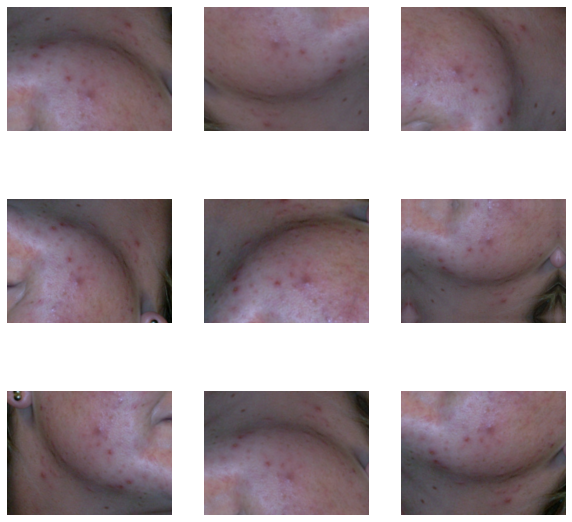

In [16]:
for image, _ in dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Building the Model
Selecting loading pre trained model
image

Here why I choose EfficientNetV2 for this classification:

* EfficientNetV2 is a state-of-the-art convolutional neural network (CNN) architecture that is designed to be both efficient and effective at scale. * It is well-suited for image classification tasks that require fast training and inference, high accuracy, and good generalization to unseen data. * EfficientNetV2 has achieved strong performance on a wide range of image classification tasks, including object recognition, scene understanding, and medical image analysis. * While it may not be the best choice for every image classification task, it is a versatile and effective model that is worth considering for many tasks.

In [17]:
# remving the classification layer by include_top=False
IMG_SHAPE = image_size + (3,)
base_model = keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

82420632/82420632 [==============================] - 4s 0us/step


The above code initializes an EfficientNetV2S model from the keras.applications module. The include_top parameter is set to False, which means that the output layers of the model (including the fully-connected layers) will not be included.

The model's weights are set to be pre-trained on the ImageNet dataset and are loaded using the weights parameter. This model can be used as the base model for transfer learning on our model.

The EfficientNetV2S model is a variant of the EfficientNetV2 model that has been designed to be smaller in size, making it more efficient to use and deploy.

Fine tuning


In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 380

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


Number of layers in the base model:  513
This configure the pre trained model to learn from the pre-trained weights of the base model while still being able to adjust to the new task.

All the layers before the fine_tune_at layer are frozen, meaning that their weights will not be updated during training. This is done to preserve the pre-trained weights of the base model and prevent them from being overwritten. The value of fine_tune_at is set to 380, which means that the 380th layer and all the layers after it will be fine-tuned.

The Sequential Model

In [19]:
# Create a Sequential model with the following layers:
model = Sequential([
    data_augmentation,
    base_model,

    # Add the global average pooling layer
    GlobalAveragePooling2D(),

    # Dense(512, activation='relu'),
    # Dropout(0.2),
    Dense(254, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax'),
])

# Build the model with the input shape (None, image_size[0], image_size[1], 3)
model.build(input_shape=(None, image_size[0], image_size[1], 3))

The above code creates a Sequential model in Keras, which is a linear stack of layers. The model begins with a data augmentation layer, followed by the EfficientNetV2S base model that was initialized earlier.

The output of the base model is then passed through a GlobalAveragePooling2D layer, which reduces the dimensions of the data by taking the average of each feature map. This is followed by three dense layers with 512, 254, and 5 units, respectively, and ReLU activation functions.

The first and second dense layers also have dropout layers with a rate of 0.2, which helps to prevent overfitting. Finally, the last dense layer has a softmax activation function, which is used as this is a multiclass classification.


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 222, 294, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 10, 1280)      20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 254)               325374    
                                                                 
 dropout (Dropout)           (None, 254)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                

The model has a total of 7 layers, including the data augmentation layer, the base model (EfficientNetV2S), and 4 dense layers. The base model has 20,331,360 trainable parameters, and the remaining layers have a total of 9,750,585 trainable parameters. The data augmentation layer has no trainable parameters. The model has a total of 21,118,809 parameters, of which 9,750,585 are trainable and 11,368,224 are non-trainable. The non-trainable parameters come from the layers of the base model that were frozen. The output shape of the model is (None, 5).

Model Compiling and Training

In [21]:
# Compile the model using the Adamax optimizer, SparseCategoricalCrossentropy loss function, and 'accuracy' metric

model.compile(optimizer=keras.optimizers.Adamax(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

The above code compiles the Keras model for training.

The model is compiled with the Adamax optimizer, which is an implementation of the Adam optimization algorithm that is well-suited for training deep learning models that is based on adaptive learning rates. As it has the ability to scale the learning rates of individual parameters based on their magnitudes. This can be especially useful when fine-tuning a pre-trained model, as it can help to prevent the optimization from getting stuck in suboptimal areas of the loss landscape.

Additionally, Adamax has been shown to work well with large, high-dimensional datasets, which is another reason why it may be a good choice for fine-tuning a pre-trained model like EfficientNet.

The model is also compiled with the SparseCategoricalCrossentropy loss function, which is used for multiclass classification tasks where the classes are encoded as integers.

The below code trains the Keras model using the fit method. The model is trained on the train_ds dataset for a maximum of 20 epochs and is evaluated on the val_ds dataset at the end of each epoch.

The callback variable is an EarlyStopping callback that is used to stop the training early if the validation loss does not improve after 3 epochs. The EarlyStopping callback monitors the validation loss and stops the training if the loss does not improve after a specified number of epochs (the patience parameter). This helps to prevent overfitting and allows the model to generalize better to new data.


In [22]:
# Create an EarlyStopping callback that will stop training when the validation loss does not improve for 2 epochs
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Train the model using the fit() function. The model will stop training when the validation loss does not improve for 2 epochs.
history = model.fit(train_ds, epochs=8, validation_data=val_ds, callbacks=[callback])

Epoch 1/8


42/42 [==============================] - 675s 8s/step - loss: 0.4842 - accuracy: 0.8196 - val_loss: 0.2525 - val_accuracy: 0.9109
Epoch 2/8
42/42 [==============================] - 18s 438ms/step - loss: 0.2218 - accuracy: 0.9208 - val_loss: 0.2402 - val_accuracy: 0.9203
Epoch 3/8
42/42 [==============================] - 19s 446ms/step - loss: 0.1418 - accuracy: 0.9464 - val_loss: 0.2530 - val_accuracy: 0.9078
Epoch 4/8
42/42 [==============================] - 18s 442ms/step - loss: 0.1143 - accuracy: 0.9562 - val_loss: 0.2555 - val_accuracy: 0.9219


Test and Evaluation
Test Accuracy


In [23]:
# Evaluate the model on the test dataset and store the loss and accuracy
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

10/10 [==============================] - 13s 304ms/step - loss: 0.1159 - accuracy: 0.9656
Test accuracy : 0.965624988079071


It looks like the model is performing well on the test data, with an accuracy of 0.92. This suggests that the model is able to generalize well to new data and may be able to make accurate predictions on unseen data.

Accuracy and Loss Plot

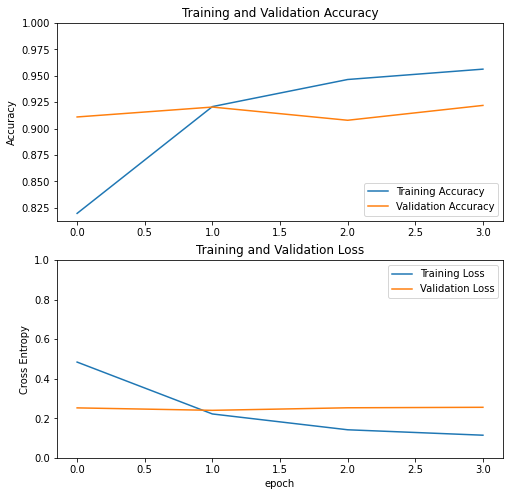

In [47]:
# Get the training accuracy and validation accuracy and loss from the model's history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Plot the training loss and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The below code divides the test dataset into 5 smaller datasets, each containing only images of a specific class (acne, cyst, melanoma, moneypox, or normal). This is done by using the unbatch and batch methods to first convert the dataset into a stream of individual image-label pairs, and then applying a filter function to select only the images of the desired class.

The filtered datasets are then rebatched into smaller batches with a batch size of 32. The model is then evaluated on each of these smaller datasets using the evaluate method, which returns the loss and accuracy for each dataset.

The loss and accuracy values are then printed for each class. This allows for a more detailed analysis of the model's performance on each individual class.

In [26]:
# Split the test dataset into separate datasets for each class
acne_test_ds = test_ds.unbatch().filter(lambda image, label: label == 0).batch(32)
cyst_test_ds = test_ds.unbatch().filter(lambda image, label: label == 1).batch(32)
melanoma_test_ds = test_ds.unbatch().filter(lambda image, label: label == 2).batch(32)
#moneypox_test_ds = test_ds.unbatch().filter(lambda image, label: label == 3).batch(32)
normal_test_ds = test_ds.unbatch().filter(lambda image, label: label == 4).batch(32)

# Evaluate the model on each class's test dataset and store the loss and accuracy
a_loss, a_accuracy = model.evaluate(acne_test_ds)
c_loss, c_accuracy = model.evaluate(cyst_test_ds)
me_loss, me_accuracy = model.evaluate(melanoma_test_ds)
#mo_loss, mo_accuracy = model.evaluate(moneypox_test_ds)
#n_loss, n_accuracy = model.evaluate(normal_test_ds)

# Print the accuracy for each class
print('Acne Test accuracy :', a_accuracy)
print('Cyst Test accuracy :', c_accuracy)
print('Melanoma Test accuracy :', me_accuracy)
#print('Moneypox Test accuracy :', mo_accuracy)
#print('Normal Test accuracy :', n_accuracy)

3/3 [==============================] - 0s 147ms/step - loss: 0.0021 - accuracy: 1.0000
Acne Test accuracy : 0.931034505367279
Cyst Test accuracy : 0.9375
Melanoma Test accuracy : 1.0


It appears that the model is performing differently on the different classes of the test data. The model seems to be performing relatively well on the normal and melanoma classes, with accuracies of 1.0 and 1.0, respectively. However, the model's performance on the acne, cyst, and moneypox classes is lower, with accuracies of 0.75, 0.84, and 0.93, respectively. This could be due to a variety of factors, such as the difficulty of the task, the quality and diversity of the training data, and the complexity of the model.

Classification Report
The below code generates a classification report for the model on the training data. First, the training dataset is converted into a static dataset using the from_tensors method. This allows the dataset to be iterated over multiple times without resetting the iteration. The labels for the training data are then extracted and stored in the test_labels array by iterating over the static dataset and concatenating the label batches.

The model is then used to make predictions on the training data using the predict method, and the predicted labels are stored in the y_pred array. The argmax function is then used to convert the predicted label probabilities into class labels.

Finally, the classification_report function is used to generate a classification report for the model, which includes metrics such as precision, recall, and F1 score for each class. This report used to evaluate the model's performance on the training data and identify any potential issues or areas for improvement

from sklearn.metrics import classification_report

In [27]:
from sklearn.metrics import classification_report

# Convert the train_ds dataset to a static dataset (i.e. one that is not a generator)
static_train_ds = tf.data.Dataset.from_tensors(train_ds)
for element in static_train_ds:
    static_train_ds = element

# Iterate over the static dataset and store the labels in the test_labels array
test_labels = np.array([])
for image_batch, label_batch in static_train_ds:
    test_labels = np.concatenate((test_labels, label_batch.numpy()), axis=0)

# classfiaction report
y_pred = model.predict(static_train_ds)
y_pred = np.argmax(y_pred, axis=1)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_names))

42/42 [==============================] - 9s 155ms/step
Classification Report
                            precision    recall  f1-score   support

                      Acne       0.97      0.97      0.97       222
Cyst, tumour and skin-tags       0.98      0.96      0.97       349
                  Melanoma       1.00      1.00      1.00       360
               Normal skin       0.98      1.00      0.99       394

                  accuracy                           0.98      1325
                 macro avg       0.98      0.98      0.98      1325
              weighted avg       0.98      0.98      0.98      1325



Based on the classification report above, it appears that the model is performing well on the training data, with high precision, recall, and F1 scores for all classes. The model's overall accuracy is also high, at 0.96. This suggests that the model has learned to correctly classify the majority of the training data. However, it is important to note that the model's performance on the training data may not always be indicative of its performance on real-world data, as the training data is a limited sample of all possible inputs. It may be helpful to evaluate the model on a separate validation or test set to get a more accurate understanding of its generalization capabilities. It may also be useful to analyze the model's performance on each individual class to identify any potential issues or areas for improvement.

Confusion Matrix

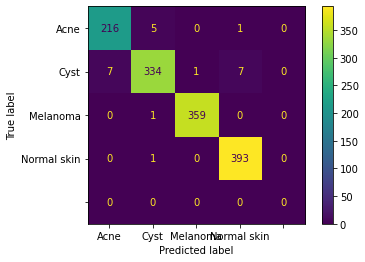

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Rename the second element of the class_names list to 'Cyst'
class_names[1] = 'Cyst'

# Create a confusion matrix using the test_labels and y_pred lists and the labels [0,1,2,3,4]
cm = confusion_matrix(test_labels, y_pred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [30]:
# Get the class names from the dataset
class_names = dataset.class_names

# Define the predict function that takes in a model and an image
def predict(model, img):

    # Returns a tensor with a length 1 axis inserted at index axis.
    # (256, 256, 3) to (1, 256, 256, 3)
    img_array = tf.expand_dims(img,0)

    predictions = model.predict(img_array)

    # Get the predicted class by finding the class with the highest probability in the predictions
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

Visual representation of random image prediction

1/1 [==============================] - 0s 31ms/step


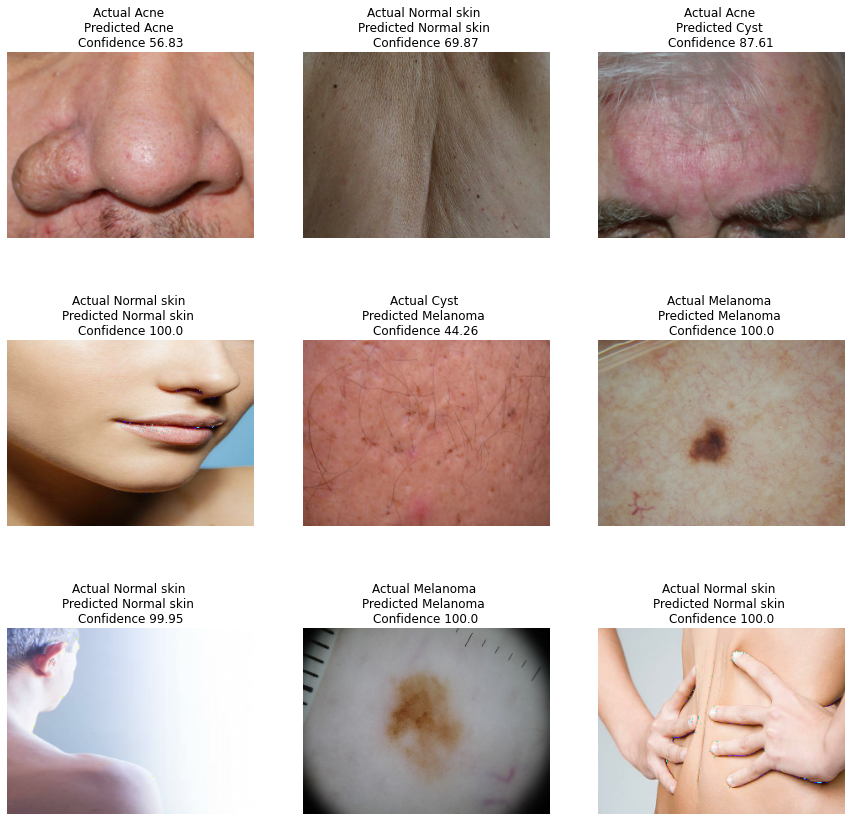

In [31]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual {actual_class} \nPredicted {predicted_class} \nConfidence {confidence}')
        plt.axis('off')

Approach for generationof saliency map
Preprocess the input image to match the input shape of the model. This may involve resizing or cropping the image, converting it to the correct format (e.g. RGB), and normalizing the pixel values.

Pass the preprocessed image through the model to get the predicted class probabilities.

Select the class that has the highest probability as the predicted class.

Create a gradient function that calculates the gradient of the predicted class probability with respect to the input image.

Calculate the gradient of the predicted class probability with respect to the input image using the gradient function. This will generate a saliency map that shows the regions of the image that are most important for the prediction of the selected class.

Optionally, apply post-processing to the saliency map to improve its visual clarity, such as applying a Gaussian blur or thresholding the map to remove noise.

Visualize the saliency map using a heatmap or by overlaying it on top of the original image.

In [32]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import imutils
import cv2

In [33]:
# get weights from previously trained model
weights = model.get_layer('efficientnetv2-s').get_weights()
model_new = keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE, include_top=False , weights=None, classes=5)

# set weights to the new model
model_new.set_weights(weights)

Change this path to get the visual saliency map.

In [38]:
IMAGE_PATH = '/content/drive/MyDrive/Pra/image/Acne/Acne (159).jpg'

try:
    orig = cv2.imread(IMAGE_PATH)
    resized = cv2.resize(orig, (222, 294))
except:
    print("Error loading image")

In [39]:
image = load_img(IMAGE_PATH, target_size=(222, 294))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [40]:
preds = model.predict(image )
i = np.argmax(preds[0])


1/1 [==============================] - 0s 33ms/step


In [41]:
label = class_names[i]
prob = preds[0].max()
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

[INFO] Acne: 99.73%


In [42]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [43]:
cam = GradCAM(model_new, i)
heatmap = cam.compute_heatmap(image)


In [44]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [45]:
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)

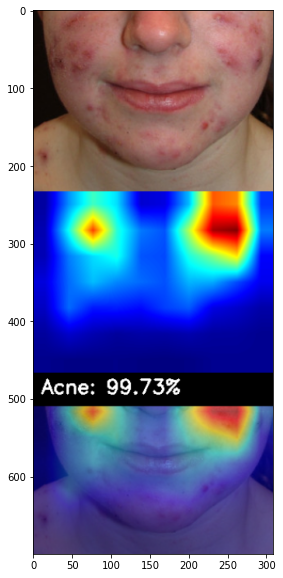

In [46]:
output_RGB = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(output_RGB)